In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from tsa.preprocessing import get_sample_info, tpm_normalization, merge_replicates
from tsa.gpr import gpr
from tsa.gene_selection import score_normalization, plot_scores, best_n_genes
from tsa.clustering import cluster_genes
from tsa.alignment import time_series_alignment
from tsa.utils import inference_timeseries, all_numeric

plt.rcParams['figure.figsize'] = [8, 6]

In [23]:
# help(time_series_alignment)

### Pinned variables
- normalization: 5 TPM minimum, quantile normalization & log transformation
- template GPR with 10 points/timepoint
- distance metric: correlation

In [3]:
tpm_file = "data/GRCz11-TPM.tsv"
tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

template_samples_file = "data/white_mpf_samples.tsv"
query_samples_file = "data/levin_mpf_samples.tsv"
# query_samples_file = "data/white_mpf_samples.tsv"  # control
# query_samples_file = "data/marletaz_mpf_samples.tsv"

# currently ran for 
# 18906 genes with min(TPM) > 5 and median(TPM) > 0 (2 ConvergenceWarnings: gene 4096 and 4817)
# with 171 points (10 per original timepoint)
new_gpr = False
gpr_inference_file = "data/white_mpf_gpr.tsv"
gpr_scores_file = "data/white_mpf_score.tsv"

showcase_gene = "ENSDARG00000000212"

In [4]:
# tpm_file = "data/XT9.1-TPM.tsv"
# tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

# template_samples_file = "data/owensA1_mpf_samples.tsv"
# # query_samples_file = "data/owensA2_mpf_samples.tsv"
# query_samples_file = "data/owensB1_mpf_samples.tsv"
# # query_samples_file = "data/tanA_mpf_samples.tsv"
# # query_samples_file = "data/tanB_mpf_samples.tsv"

# new_gpr = False
# gpr_inference_file = "data/owensA1_mpf_gpr.tsv"
# gpr_scores_file = "data/owensA1_mpf_score.tsv"

# showcase_gene = "ENSXETG00000000002"

In [5]:
# # start f-ing around with stages instead of mpf

# tpm_file = "data/GRCz11-TPM.tsv"
# tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

# template_samples_file = "data/white_stage_samples.tsv"
# # query_samples_file = "data/levin_stage_samples.tsv"
# query_samples_file = "data/levin_mpf_samples.tsv"
# # query_samples_file = "data/white_stage_samples.tsv"  # control
# # query_samples_file = "data/marletaz_mpf_samples.tsv"

# # currently ran for 
# # 18906 genes with min(TPM) > 5 and median(TPM) > 0 (2 ConvergenceWarnings: gene 4096 and 4817)
# # with 171 points (10 per original timepoint)
# new_gpr = False
# gpr_inference_file = "data/white_mpf_gpr.tsv"
# gpr_scores_file = "data/white_mpf_score.tsv"

# showcase_gene = "ENSDARG00000000212"

### GPR of all template genes

In [6]:
# preprocessing
template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
template_sample_order, template_time2samples = get_sample_info(template_samples)

template_tpms = tpm_normalization(tpms, template_sample_order, min_value=5, min_median_value=0, verbose=True)

timepoints_per_sample = 10
extended_timepoints = inference_timeseries(list(template_time2samples), timepoints_per_sample)

template_tpms.head(3)

11063 genes with max below 5 TPM (34%)
2243 genes with median below or equal to 0 TPM (10%)
18906 genes, 90 samples left after filtering


,1-cell-1,1-cell-2,1-cell-3,1-cell-4,1-cell-5,2-cell-1,2-cell-2,2-cell-3,2-cell-4,2-cell-5,...,Day-4-1,Day-4-2,Day-4-3,Day-4-4,Day-4-5,Day-5-1,Day-5-2,Day-5-3,Day-5-4,Day-5-5
gene,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000001,3.500623,3.193223,2.993834,3.134451,2.930888,3.063963,3.358324,3.177872,3.182704,3.292535,...,1.268145,0.875185,1.372952,0.953276,1.219284,1.252780,1.293310,1.701401,1.087258,0.985310
ENSDARG00000000002,1.798363,1.850706,1.549031,1.842664,1.618451,2.919417,2.731890,2.547173,2.881035,2.495728,...,2.909071,3.259391,3.423040,3.203155,2.933308,3.054464,3.049627,3.124625,2.925538,3.317229
ENSDARG00000000018,3.825139,3.883515,3.443959,3.688393,3.947403,4.004615,4.161532,4.129312,4.164329,3.913867,...,4.537668,4.042059,4.059302,4.259864,4.103876,4.459250,4.421675,4.362885,4.252356,4.371778


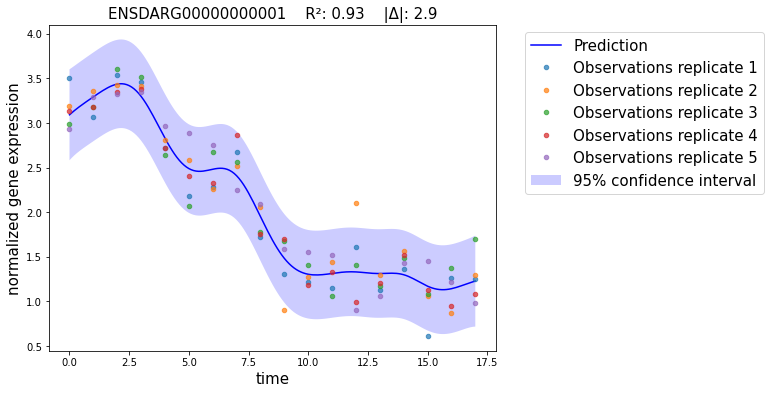

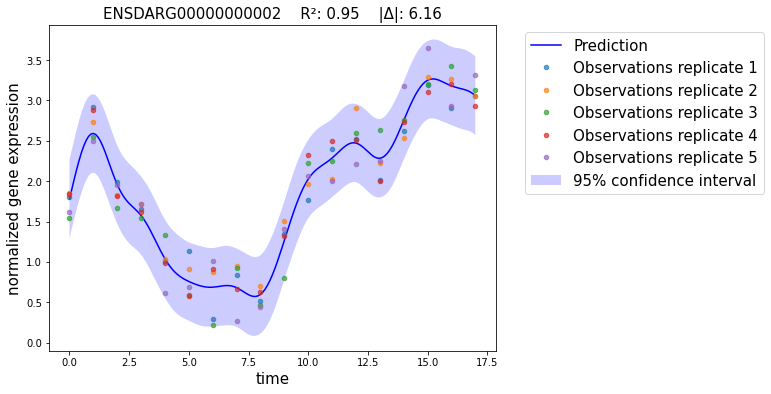

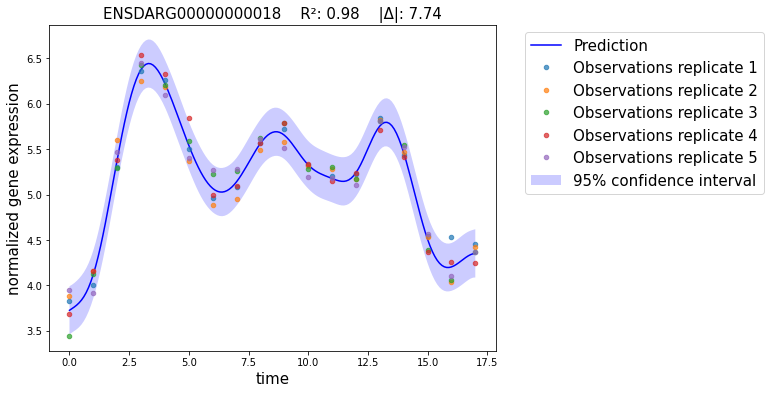

In [7]:
# run 3x with pictures
template_tpms_inf, gpr_scores = gpr(template_time2samples, template_tpms, extended_timepoints, plot=True, verbose=False, run_n=3)

if new_gpr:
    # run with all genes
    template_tpms_inf, gpr_scores = gpr(template_time2samples, template_tpms, extended_timepoints, plot=False, verbose=True, run_n=None)
    
    template_tpms_inf.to_csv(gpr_inference_file, sep="\t")
    gpr_scores.to_csv(gpr_scores_file, sep="\t")
else:
    template_tpms_inf = pd.read_csv(gpr_inference_file, sep="\t", index_col=0)
    gpr_scores = pd.read_csv(gpr_scores_file, sep="\t", index_col=0)

In [8]:
# # conver mpf to stage annotation (to test bad data)

# tps = list(template_samples.time.unique())
# tps2 = []
# for t in tps:
#     tps2.append(t)
#     for n in range(10)[1:]:
#         tps2.append(f"{t}+{n}/{10}")
        
# tps2 = tps2[:-9]
# template_tpms_inf.columns = tps2

# template_tpms_inf

### optional: filter template genes by r2, variability or both
- I filter on model accuracy only here

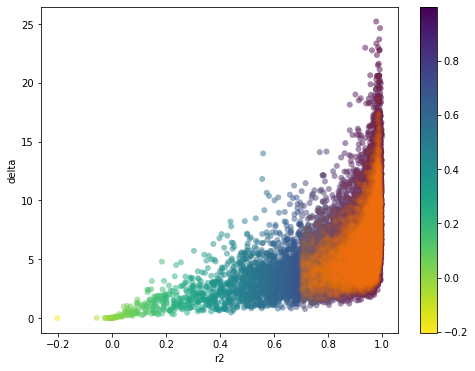

In [9]:
# remove genes that cannot weren't modelled accurately
weight_expr=0
min_r2 = 0.7
weight_r2=1

gpr_normscores = score_normalization(gpr_scores, weight_expr, weight_r2)
top_template_genes = gpr_normscores[gpr_normscores.r2 >= min_r2].index.to_list()
plot_scores(gpr_normscores, highlight_top_n=len(top_template_genes))

# n = 12_000
# top_template_genes = best_n_genes(gpr_normscores, n)
# gpr_normscores = score_normalization(gpr_scores, weight_expr=1, weight_r2=3)
# plot_scores(gpr_normscores, highlight_top_n=n)

### filter for overlapping (expressed) genes

In [10]:
# preprocessing
query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(query_samples)

target_distribution = template_tpms[template_tpms.columns[0]].to_list()
query_tpms = tpm_normalization(tpms, sample_order, min_value=5, min_median_value=0, qnorm_target_dist=target_distribution)

# TODO: other methods, such as GPR?
query_tpms = merge_replicates(query_tpms, time2samples, how="median")

if all_numeric(time2samples):
    # convert time to numeric
    samples2time = query_samples.to_dict()["time"]
    query_tpms = query_tpms.rename(columns=samples2time)
    
query_tpms.head(3)

14459 genes with max below 5 TPM (44%)
10529 genes with median below or equal to 0 TPM (59%)
7224 genes, 106 samples left after filtering


,40.0,80.0,120.0,160.0,200.0,240.0,280.0,320.0,360.0,400.0,...,3880.0,3920.0,3960.0,4000.0,4040.0,4080.0,4120.0,4160.0,4200.0,4240.0
gene,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000018,2.369168,1.301495,2.088089,2.233003,2.363797,2.148016,1.983521,1.489010,2.165915,2.339230,...,1.847458,2.110908,1.757274,2.656765,2.003061,1.937856,1.943076,1.549173,2.354088,1.827299
ENSDARG00000000019,2.395880,1.301495,1.858769,1.962128,2.411595,1.539619,2.573450,2.542626,1.388934,2.198344,...,2.049527,1.368936,0.799732,1.584256,1.621459,1.394357,0.799732,1.692398,2.109215,1.827299
ENSDARG00000000068,2.403446,1.301495,2.537220,0.895969,2.433757,2.422291,2.157344,1.489010,1.388934,1.290252,...,1.291991,0.799732,0.799732,1.584256,0.799732,1.869218,0.799732,1.969233,1.134120,1.827299


### Bootstrapping: Goodness of Fit

In [11]:
# intersection of query genes & top template genes
query_genes = query_tpms.index
starting_genes = set(top_template_genes).intersection(query_genes)

print(len(starting_genes), "overlapping genes")

template_gene_clusters = cluster_genes(template_tpms_inf, starting_genes)

6886 overlapping genes


In [12]:
# template_gene_clusters
# overlapping_genes = list(set(template_tpms_inf.index).intersection(query_tpms.index))
# len(overlapping_genes)
# starting_genes == overlapping_genes 

In [13]:
# avg_path = avg_alignment(template_tpms_inf, query_tpms, template_gene_clusters, tries=2, frac=0.01)

In [14]:
# top_gene_clusters, _ = top_cluster_genes(template_tpms_inf, query_tpms, path=avg_path, gene_cluster_df=template_gene_clusters)
# avg_path = avg_alignment(template_tpms_inf, query_tpms, top_gene_clusters, tries=1)

In [15]:
# import inspect
# import pandas as pd
# import sklearn

# from tsa.tsa import avg_alignment

# def subset_df(df, rows=None, columns=None, sort=True):
#     """
#     (efficiently) reconstruct a dataframe by row and/or column (name or number)
    
#     rows: list of row/index names or numbers
#     columns: list of column names or numbers
#     """
#     if rows:
#         if set(rows).issubset(set(df.index)):
#             # rows contains dataframe row names
#             df = df[df.index.isin(rows)]
#         else:
#             # rows contains dataframe row numbers
#             df = df.iloc[rows]
#     if columns:
#         if set(columns).issubset(set(df.columns)):
#             # columns contains dataframe column names
#             df = df[columns]
#         else:
#             # columns contains dataframe column numbers
#             df = df[[df.columns[i] for i in columns]]
#     if sort:
#         df.sort_index(inplace=True)
#     return df


# def top_cluster_genes(template_tpms_inf, query_tpms, path, gene_cluster_df, top_frac=0.2, filter_frac=0, scale=True, verbose=False):
#     # get 2 dataframe with desired genes and aligned timepoints
#     genes = list(gene_cluster_df.index)
#     template_Y = subset_df(template_tpms_inf, genes, path)
#     query_Y = subset_df(query_tpms, genes)

#     if scale:
#         # scale y-axis per gene
#         template_Y = pd.DataFrame(
#             sklearn.preprocessing.scale(template_Y, axis=1),
#             index=template_Y.index,
#             columns=template_Y.columns
#         )
#         query_Y = pd.DataFrame(
#             sklearn.preprocessing.scale(query_Y, axis=1),
#             index=query_Y.index, 
#             columns=query_Y.columns
#         )

#     # R^2: how close are the two time series? (argument order is arbitrary)
#     scores = sklearn.metrics.r2_score(query_Y.T, template_Y.T, multioutput='raw_values')
#     scores = pd.DataFrame({"gene": query_Y.index, "score": scores}).set_index("gene")

#     # combine score and cluster info per gene
#     subset = scores.merge(gene_cluster_df, left_index=True, right_index=True, how="right")
#     subset.sort_values("score", ascending=False, inplace=True)
#     if verbose:
#         print("All genes per cluster")
#         print("mean fit score:", round(subset.score.mean(), 3))
#         s = subset.groupby("cluster").score.mean()
#         g = subset.groupby("cluster").size()
#         g.name = "n_genes"
#         print(pd.concat([s, g], axis=1))
#         print()

#     filt_gene_cluster_df = gene_cluster_df
#     if filter_frac:
#         # drop the bottom fraction of each cluster
#         keep = []
#         for cluster in subset.cluster:
#             subset_cluster = subset[subset.cluster==cluster]
#             top_n = int(len(subset_cluster)*(1-filter_frac))
#             keep.extend(list(subset_cluster.head(top_n).index))
#         subset = subset[subset.index.isin(keep)]
#         filt_gene_cluster_df = gene_cluster_df[gene_cluster_df.index.isin(keep)]
    
#     if top_frac:
#         # take the top fraction of each cluster
#         subset = subset.groupby("cluster").apply(lambda x: x.head(int(len(x)*top_frac))).reset_index(drop=True)
    
#     if verbose:
#         print("Top genes per cluster")
#         print("mean fit score:", round(subset.score.mean(), 3))
#         s = subset.groupby("cluster").score.mean()
#         g = subset.groupby("cluster").size()
#         g.name = "n_genes"
#         print(pd.concat([s, g], axis=1))
    
#     subset = subset.index.to_list()
#     top_gene_cluster_df = gene_cluster_df[gene_cluster_df.index.isin(subset)]
    
#     return top_gene_cluster_df, filt_gene_cluster_df


# def bootstrap_alignment(template, query, gene_cluster_df=None, tries=10, frac=0.2, cycles=1, top_frac=0.6, filter_frac=0.2, method="skip_worst", verbose=True, **kwargs):
#     """
#     Apply a local time series alignment of {query} to {template}.
#     Returns the path (and standard deviation if {return_std} is True) for each cycle.
#     The path contains the indeces of {template} columns best matching each {query} column.
    
#     Uses a random {frac}tion of genes (per cluster of genes if {gene_cluster_df} is provided).
#     This is repeated several {tries}, and averaged to obtain an alignment path.
    
#     If {cycles} > 1, the alignments will then be used to bootstrap a subsequent alignments:
    
#     First by measuring the ({scale}d) Goodness of Fit for each gene, 
#     and discarding the worst {filter_frac}tion genes (per cluster) between cycles.
#     Second, if {method} is 'use_best', the {top_frac}tion of remaining genes is subset, 
#     else if {method} is 'discard_worst', all remaining genes are subset.
#     Finally, the subset genes are used for the next cycle's average alignment 
#     (the subset is recreated from all remaining genes each cycle).
    
#     Parameters
#     ----------
#     template: pd.DataFrame
#         dataframe with gene names as index and expression values at a timepoint per column.
#         Columns are assumed to be sorted chronologically, and the time range to contain the query time range.
#         If column names can be converted to numeric in query and template, this is used to improve plots.
#     query: pd.DataFrame
#         dataframe with gene names as index and expression values at a timepoint per column.
#         Columns are assumed to be sorted chronologically, and the time range to be contained by the template time range.
#         If column names can be converted to numeric in query and template, this is used to improve plots.

#     Alignment parameters
#     --------------------
#     gene_cluster_df: pd.DataFrame, optional
#         optional dataframe with gene names as index and a column "cluster" with gene clusters
#     tries: int, optional
#         numer of times the alignment is performed per average. Default is 10
#     frac: float, optional
#         fraction of genes to use (per cluster) for alignment
#     metric: string, optional
#         distance metric to apply for the TSA. See scipy's cdist for options. Default is 'correlation'
    
#     Bootstrap parameters
#     --------------------
#     cycle: int, optional
#         number of alignment cycles to perform. Bootstrapping takes effect with cycle > 1
#     top_frac: float, optional
#         fraction of best genes to keep between cycles
#     filter_frac: float, optional
#         fraction of worst genes to discard between cycles
#     method: string, optional
#         bootstrap gene filter method. With "use_best" "skip_worst"
#     scale: bool, optional
#         wether to scale the expression values before determining Goodness of Fit
    
#     Other parameters
#     ----------------
#     verbose: bool, optional
#         wether to return additional messages on progress and gene usage. Default is True
#     return_std: bool, optional
#         wether to return standard deviation of the average alignment
#     plot: bool, optional
#         wether to plot the alignment (and showcase_gene for each alignment)
#     showcase_gene: string, optional
#         specify a gene name to plot after each alignment. Uses a random gene if None (default).
        
#     Returns
#     -------
#     paths: list
#         if cycle == 1, containing the template columns indeces best matching the query columns. Each column being a timepoint.
#         if cycle >1, a list of lists with a path for each cycle.
#         if return_std = True, returns tuple(s) containing the path and the standard deviation in aligned template indeces (both up and down).
#     """
#     if method not in ["skip_worst", "use_best"]:
#         raise ValueError("`method` can be either 'skip_worst' or 'use_best'")
#     if frac > 1 or frac < 0:
#         raise ValueError("`frac` must be within [0,1]")
#     if top_frac > 1 or top_frac < 0:
#         raise ValueError("`top_frac` must be within [0,1]")
#     if filter_frac > 1 or filter_frac < 0:
#         raise ValueError("`filter_frac` must be within [0,1]")
#     if filter_frac == 0 and top_frac == 1:
#         raise ValueError("You must filter genes with `top_frac` and/or `filter_frac` to bootstrap")
#     if filter_frac == 0:
#         method = "use_best"
#     elif top_frac == 1:
#         method = "skip_worst"

#     # filter kwargs for subfunctions
#     alignment_kwargs = {}
#     cluster_kwargs = {}
#     if kwargs:
#         keys = inspect.getfullargspec(avg_alignment).args
#         alignment_kwargs = {k: kwargs[k] for k in keys if k in kwargs}
#         keys = inspect.getfullargspec(top_cluster_genes).args
#         cluster_kwargs = {k: kwargs[k] for k in keys if k in kwargs} 
    
#     # match query and template index order
#     if gene_cluster_df is None:
#         overlapping_genes = list(set(template.index).intersection(query.index))
#         template = template.loc[overlapping_genes]
#         query = query.loc[overlapping_genes]
#         # use all overlapping genes if no cluster information is provided
#         gene_cluster_df = pd.DataFrame({
#             "gene1": overlapping_genes, 
#             "cluster": [0 for _ in  range(len(overlapping_genes))]
#         }).set_index("gene1")
#     else:
#         template = template.loc[gene_cluster_df.index]
#         query = query.loc[gene_cluster_df.index]
    
#     # initial TSA
#     if verbose and cycles > 1:
#         print(f"Cycle 1, using all {len(gene_cluster_df)} genes.\n")
#     path = avg_alignment(template, query, gene_cluster_df, tries=tries, frac=frac, **alignment_kwargs)
#     if cycles == 1:
#         return path
    
#     # bootstrapped TSA's
#     # return a list of average paths per cycle
#     paths = [path]
#     filt_gene_clusters = gene_cluster_df
#     for n in range(cycles)[1:]:
#         top_gene_clusters, filt_gene_clusters = top_cluster_genes(template, query, path, gene_cluster_df=filt_gene_clusters, top_frac=top_frac, filter_frac=filter_frac, **cluster_kwargs)
        
#         # use the best fraction of genes, or all genes minus the worst fraction.
#         cluster_method = top_gene_clusters if method == "use_best" else filt_gene_clusters
#         if verbose:
#             if method == "use_best":
#                 print(f"Cycle {n+1}, using the best {len(top_gene_clusters)} of {len(filt_gene_clusters)} genes.\n")
#             else:
#                 print(f"Cycle {n+1}, using the best {len(filt_gene_clusters)} genes.\n")
        
#         path = avg_alignment(template, query, cluster_method, tries=tries, frac=frac, **alignment_kwargs)
#         paths.append(path)
#     return paths

In [16]:
# import inspect
# inspect.getdoc(time_series_alignment)

Cycle 1, using all 6886 genes.

Average TSA of 2 alignments with 20% of genes per cluster 
(22 clusters, 1377 total genes)


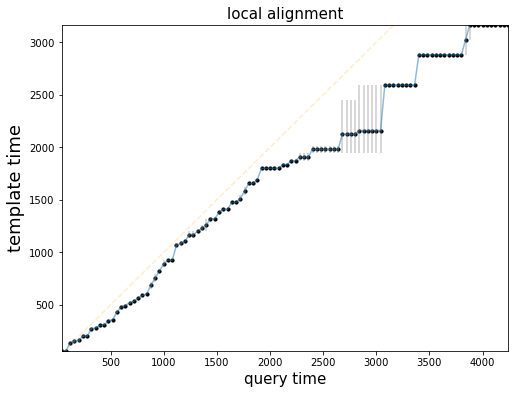

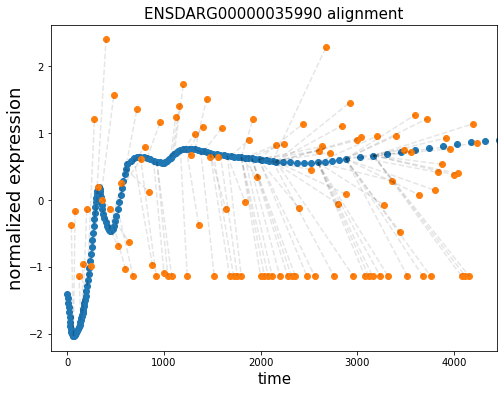

Cycle 2, using the best 5499 genes.

Average TSA of 2 alignments with 20% of genes per cluster 
(22 clusters, 1101 total genes)


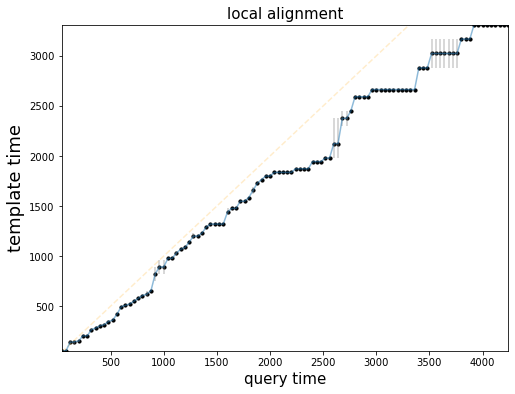

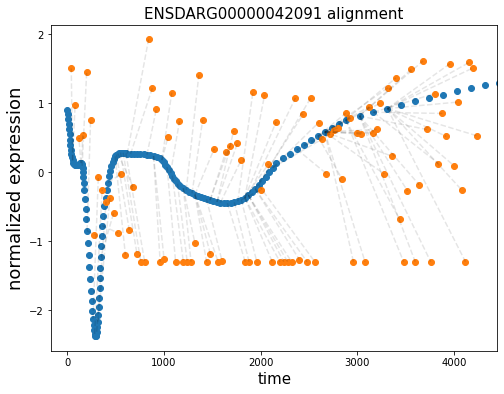

In [17]:
paths2 = time_series_alignment(template_tpms_inf, query_tpms, template_gene_clusters, cycles=2, tries=2, plot=True)
# paths3 = bootstrap_alignment(template_tpms_inf, query_tpms, cycles=2, tries=1, plot=True, scale=False)

In [18]:
# overlapping_genes = list(set(top_template_genes).intersection(query_tpms.index))
# test = pd.DataFrame({"cluster": [1 for _ in  range(len(starting_genes))]}, index=starting_genes)#.set_index("gene")
# test
# len(test) == len(template_gene_clusters)

# q1 = query_tpms[query_tpms.index.isin(starting_genes)]
# q2 = query_tpms[query_tpms.index.isin(starting_genes[::-1])]
# q1.index.equals(q2.index)

# query_tpms.index.equals(template_tpms_inf.index)
# q = query_tpms[query_tpms.index.isin(starting_genes)]
# t = template_tpms_inf[template_tpms_inf.index.isin(starting_genes)]
# q.index.equals(t.index)

# template_tpms_inf.loc[template_gene_clusters.index]

In [19]:
# def test(**kwargs):
#     print(kwargs)
#     keys = inspect.getfullargspec(avg_alignment).args
#     alignment_kwargs = {k: kwargs[k] for k in keys if k in kwargs}
#     print(alignment_kwargs)
# #     dict_you_want = { your_key: kwargs[your_key] for your_key in ["k2"] }
# #     print(dict_you_want)
    
# test(plot=True, k2="dsa")

Average TSA of 10 alignments with 20% of genes per cluster 
(22 clusters, 1377 total genes)


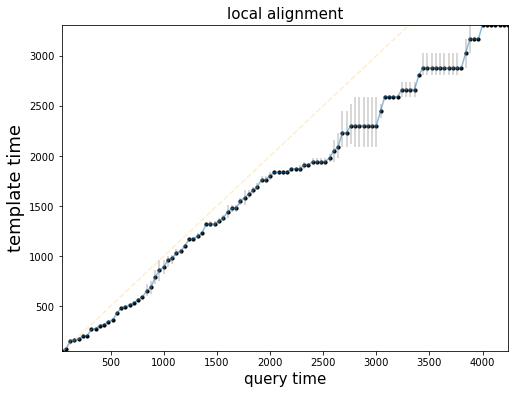

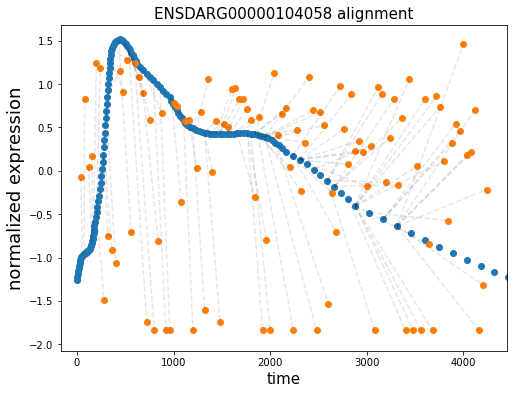

In [20]:
paths = time_series_alignment(template_tpms_inf, query_tpms, template_gene_clusters, cycles=1, tries=10, frac=0.2, filter_frac=0)

### for show

In [21]:
from tsa.utils import list2floats


old_mapping = 'data/white_mpf_levin_mpf_mapping.tsv'
# old_mapping = 'data/white_mpf_white_mpf_mapping.tsv'
# old_mapping = 'data/white_mpf_marletaz_mpf_mapping.tsv'

df = pd.read_csv(old_mapping, sep="\t")
old_query_time = df.inferred_time.to_list()
# old_query_time

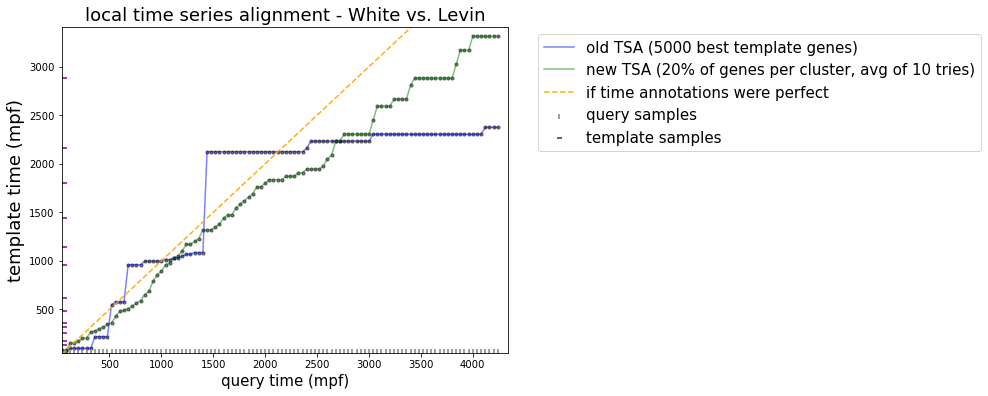

In [22]:
q = list2floats(query_tpms.columns)
t0 = old_query_time                           # old alignment
t1 = [extended_timepoints[i] for i in paths]  # new alignment

plt.plot(q, t0, alpha=0.5, color="blue", label='old TSA (5000 best template genes)')
plt.scatter(q, t0, alpha=0.5, s=10, color="black")

plt.plot(q, t1, alpha=0.5, color="green", label='new TSA (20% of genes per cluster, avg of 10 tries)')
plt.scatter(q, t1, alpha=0.5, s=10, color="black")

# annotated time of original samples
my = min(t0[0], t1[0])+20
plt.scatter(q, [my for i in t0], alpha=1, s=25, color="grey", label='query samples', marker='|')

mx = q[0]+20
tp = list(template_time2samples)
plt.scatter([mx for i in tp], tp, alpha=1, s=25, color="purple", label='template samples', marker='_')

# add diagonal
start = min(t0[0], t1[0], q[0])
end = max(t0[-1], t1[-1], q[-1])
plt.plot([start, end], [start, end], color='orange', label="if time annotations were perfect", alpha=0.9, ls='--')

plt.ylim(min(t0[0], t1[0]), max(t0[-1], t1[-1])+100)  # a bit extra added
plt.xlim(q[0], q[-1]+100)  # a bit extra added

plt.title("local time series alignment - White vs. Levin", fontsize=18)
plt.ylabel("template time (mpf)", fontsize=18)
plt.xlabel("query time (mpf)", fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)
plt.show()